# Config and Imports

In [1]:
import os
os.chdir('../../')
prj_path = "./data/IGs/"
print(os.getcwd())

c:\Users\andri\Progetti\igraph_transformer


In [2]:
import random

import os
import torch
import pickle
import torch.utils.data
import time

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from data.IGs import IGsDatasetDGL, IGsDataset

Using backend: pytorch


# Prepare dataset

txt --> train/test/val PKL: NO DGL

In [3]:
def track_list_to_adjacency_matrix(track_list):
    # Determine the maximum number of nodes in the track
    # num_nodes = max(track_list) + 1
    num_nodes = 16

    # Create an empty adjacency matrix
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]

    # Add connections to the adjacency matrix
    for i in range(len(track_list) - 1):
        current_node = track_list[i]
        next_node = track_list[i + 1]
        adjacency_matrix[current_node][next_node] = 1

    return adjacency_matrix


data_list = []
dataset = []

with open(prj_path + 'ig_subgraphs.txt', 'r') as file:
    for line in file:
        line = line.strip()  # Remove whitespace and newline characters
        values = line.split(']')  # Split the line based on the ']' character
        nums = values[0].strip('[, ')  # Extract the numbers inside the square brackets
        nums = [int(num) for num in nums.split(',')]  # Convert the numbers into a list of integers
        num_after_bracket = int(values[1].strip())  # Extract the number after the square bracket
        data_list.append([nums, num_after_bracket])

random.shuffle(data_list)

for data in data_list:
    obj = {
        'num_node': len(data[0]),
        'node_type': torch.tensor(data[0], dtype=torch.int8),
        'adj' : torch.tensor(track_list_to_adjacency_matrix(data[0]), dtype=torch.int8),
        'target': torch.tensor(data[1])
    }
    dataset.append(obj)

with open(prj_path + 'igraph-GTN.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [7]:
len(dataset)

72285

### Split and Dump train,val,test pkl

In [37]:
from torch.utils.data import SubsetRandomSampler, DataLoader
from collections import defaultdict
# Create dictionary to keep track of indices for each class label
indices = defaultdict(list)
for i, data in enumerate(dataset):
    label = data['target']
    indices[label.item()].append(i)
    
    
# TRAIN------------------------------------------------------------------------
# Sample balanced subset of indices from each class for train set
train_indices = []
for label_indices in indices.values():
  
    num_samples = len(label_indices)
    num_train_samples = int(0.7 * num_samples)  # 70-30 split between train and validation
    
    train_indices += random.sample(label_indices, num_train_samples)
    
    random.shuffle(train_indices)
    
train = [dataset[i] for i in train_indices]
# train = [dataset[i] for i in train_indices[0:100]]

# Sample balanced subset of indices from each class for test set
test_indices = []


# TEST-------------------------------------------------------------------------
for label_indices in indices.values():
    num_test_samples = int(0.2 * len(label_indices))  # 70-20-10 split between train, validation, and test
    
    label_indices = set(label_indices) - set(train_indices)  # Remove train indices from consideration
    test_indices += random.sample(label_indices, num_test_samples)
    
    random.shuffle(test_indices)
    
test = [dataset[i] for i in test_indices]
# test = [dataset[i] for i in test_indices[0:100]]

# VALIDATION-------------------------------------------------------------------
# Sample balanced subset of indices from each class for val set
val_indices = []
for label_indices in indices.values():
    label_indices = set(label_indices) - set(train_indices) - set(test_indices)  # Remove train and validation indices from consideration
    val_indices += label_indices
    # test_indices += random.sample(label_indices, 20)
    # num_val_samples = int(0.1 * len(label_indices))  # 70-20-10 split between train, validation, and test
    # val_indices += random.sample(label_indices, num_val_samples)
    random.shuffle(val_indices)
val = [dataset[i] for i in val_indices] 
# val = [dataset[i] for i in val_indices[0:100]] 

print(f"Size of train set is {len(train)}")
print(f"Size of test set is {len(test)}")
print(f"Size of val set is {len(val)}")

Size of train set is 50595
Size of test set is 14454
Size of val set is 7236


In [38]:
test[10:13]

[{'num_node': 2,
  'node_type': tensor([0, 1], dtype=torch.int8),
  'adj': tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0

In [39]:
#train, test_val_data = train_test_split(dataset, test_size=0.3, random_state=42)
#test, val = train_test_split(test_val_data, test_size=0.7, random_state=42)

start = time.time()
with open(prj_path + 'igraph-GTN-train.pkl','wb') as f:
        pickle.dump(train, f)
with open(prj_path + 'igraph-GTN-test.pkl','wb') as f:
        pickle.dump(test, f)
with open(prj_path + 'igraph-GTN-val.pkl','wb') as f:
        pickle.dump(val, f)

print('Time (sec):',time.time() - start)

Time (sec): 10.218509674072266


# Load Dataset

In [40]:
if not os.path.isfile(prj_path + 'igraph-DatasetDGL.pkl'):
  # file presente --> pkl load
  # with open(prj_path + 'igraph-DatasetDGL.pkl', "rb") as f:
  #   f = pickle.load(f)
  #   datasetDGL = f
  datasetDGL = IGsDataset()
else:
  # dataset non presente -> generazione
  datasetDGL = IGsDatasetDGL()

  start = time.time()
  with open(prj_path + 'igraph-DatasetDGL.pkl', 'wb') as f:
          #pickle.dump([datasetDGL.train,datasetDGL.val,datasetDGL.test], f)
          pickle.dump(datasetDGL, f)
  print('Time (sec):',time.time() - start)

[I] Loading data ...
preparing 50595 graphs for the TRAIN set...
preparing 7236 graphs for the VAL set...
preparing 14454 graphs for the TEST set...
[I] Finished loading.
Time taken: 370.1405s
Time (sec): 37.08786725997925


In [28]:
datasetDGL.train[1][0]

Graph(num_nodes=29, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})

In [29]:
graph, label = datasetDGL.train[0:100]
label

[tensor(10),
 tensor(14),
 tensor(10),
 tensor(6),
 tensor(4),
 tensor(2),
 tensor(10),
 tensor(7),
 tensor(5),
 tensor(4),
 tensor(13),
 tensor(8),
 tensor(8),
 tensor(3),
 tensor(15),
 tensor(2),
 tensor(5),
 tensor(13),
 tensor(6),
 tensor(2),
 tensor(2),
 tensor(5),
 tensor(15),
 tensor(6),
 tensor(12),
 tensor(7),
 tensor(9),
 tensor(11),
 tensor(6),
 tensor(6),
 tensor(9),
 tensor(8),
 tensor(4),
 tensor(13),
 tensor(3),
 tensor(9),
 tensor(11),
 tensor(13),
 tensor(8),
 tensor(13),
 tensor(7),
 tensor(4),
 tensor(13),
 tensor(7),
 tensor(15),
 tensor(11),
 tensor(9),
 tensor(13),
 tensor(7),
 tensor(2),
 tensor(9),
 tensor(10),
 tensor(11),
 tensor(3),
 tensor(3),
 tensor(8),
 tensor(9),
 tensor(5),
 tensor(3),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(14),
 tensor(10),
 tensor(7),
 tensor(14),
 tensor(9),
 tensor(9),
 tensor(3),
 tensor(3),
 tensor(15),
 tensor(4),
 tensor(12),
 tensor(5),
 tensor(9),
 tensor(6),
 tensor(12),
 tensor(15),
 tensor(12),
 tensor(15),
 tensor(11)

### Explore dataset

In [9]:
print(len(datasetDGL.train))
print(len(datasetDGL.val))
print(len(datasetDGL.test))

print(datasetDGL.train[0])
print(datasetDGL.val[0])
print(datasetDGL.test[0])

50595
6515
15175
(Graph(num_nodes=17, num_edges=12,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(10))
(Graph(num_nodes=14, num_edges=11,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(10))
(Graph(num_nodes=10, num_edges=9,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(10))


In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Count number of data instances in each class for test set
class_counts = defaultdict(int)
for i, data in enumerate(test):
    label = data['target']
    class_counts[label.item()] += 1

# Plot bar chart of class distribution for test set
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of data instances')
plt.title('Class distribution for test set')
plt.show()


NameError: name 'test' is not defined

In [7]:
# Create set of unique classes in train set
unique_classes = set()
for data in train:
    label = data['target']
    unique_classes.add(label.item())

# Count number of unique classes
num_classes = len(unique_classes)
print("Number of unique classes in train set: ", num_classes)
print(unique_classes)

NameError: name 'train' is not defined

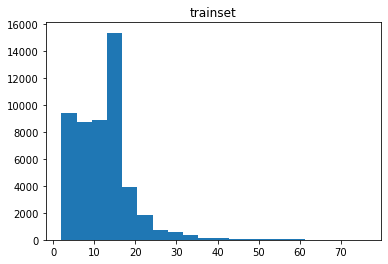

min/max : 2 76


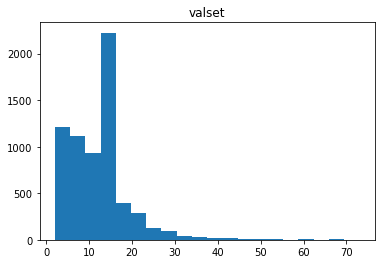

min/max : 2 73


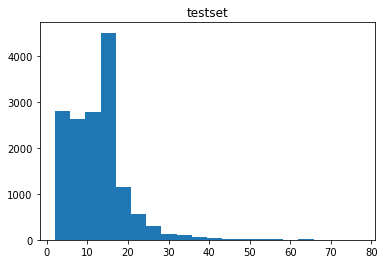

min/max : 2 77


In [8]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())

plot_histo_graphs(datasetDGL.train,'trainset')
plot_histo_graphs(datasetDGL.val,'valset')
plot_histo_graphs(datasetDGL.test,'testset')

# Test

In [50]:
train[0]

{'num_node': 14,
 'node_type': tensor([0, 1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=torch.int8),
 'adj': tensor([[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]], dtype=torch.int8),
 'target': tensor(6)}

In [68]:
datasetDGL.train[0][1].item()


6